<a href="https://colab.research.google.com/github/MostafaJahanian/Free_Projects/blob/main/alzheimer_brain_images_classification_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Data From Kaggle

In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images

 47% 16.0M/34.1M [00:00<00:00, 73.0MB/s]
100% 34.1M/34.1M [00:00<00:00, 113MB/s] 


In [ ]:
! unzip alzheimers-dataset-4-class-of-images.zip

## Create Datasets From Images

In [6]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import random
import pathlib
import cv2

In [7]:
train_dir = pathlib.Path('/content/Alzheimer_s Dataset/train')
test_dir = pathlib.Path('/content/Alzheimer_s Dataset/test')
train_dir, test_dir

(PosixPath('/content/Alzheimer_s Dataset/train'),
 PosixPath('/content/Alzheimer_s Dataset/test'))

In [8]:
class_names = keras.utils.image_dataset_from_directory('/content/Alzheimer_s Dataset/train').class_names
class_names

Found 5121 files belonging to 4 classes.


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [9]:
train_images_dir = []
for label in class_names:
  train_images_dir.append(list(train_dir.glob(f'{label}/*')))

for i in range(len(class_names)):
  print(f'{class_names[i]} : {len(train_images_dir[i])}')

MildDemented : 717
ModerateDemented : 52
NonDemented : 2560
VeryMildDemented : 1792


--- It is obvious that this dataset suffers from severe imbalanced classes distribution. While the number of samples belonging to the class 'ModeratDemented' are less than 100, number of samples in each of the other classes are at least 700. That is to say, before training any models with the given data, an extra step is needed in order to tackle this issue. 

In [10]:
images_dict = dict(zip(class_names, train_images_dir))

train_images, train_labels = [], []
for key in images_dict:
  for path in images_dict[key]:
    image = cv2.resize(cv2.imread(str(path)), (240, 240))
    train_images.append(image)
    train_labels.append(class_names.index(key))

train_images = np.array(train_images)
train_labels = np.array(train_labels)

train_images.shape, train_labels.shape

((5121, 240, 240, 3), (5121,))

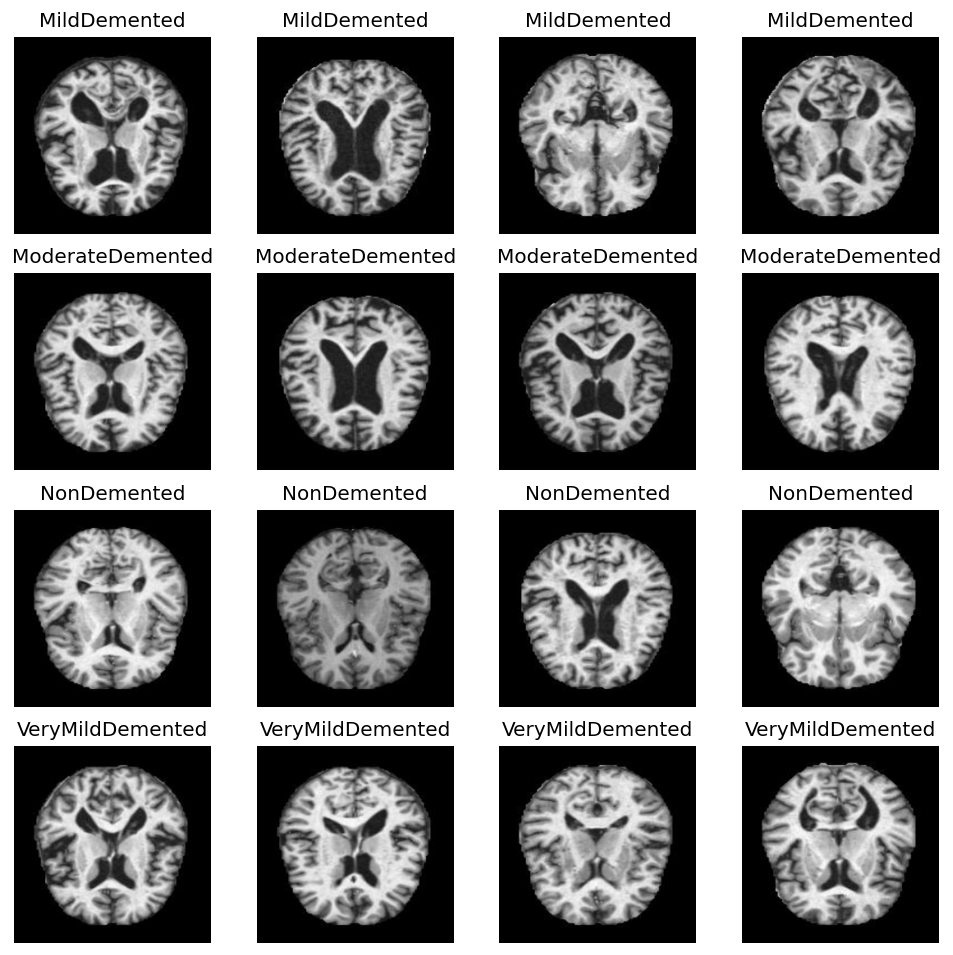

In [11]:
target_labels, printed_labels = [0, 1, 2, 3], []
plt.figure(figsize = (10, 10), dpi = 120)
count = 0

for i in range(len(train_images)):

  if printed_labels.count(train_labels[i]) == 4 and train_labels[i] in target_labels:
    target_labels.remove(train_labels[i])

  if len(target_labels) == 0:
    break
  
  if train_labels[i] in target_labels:
    ax = plt.subplot(4, 4, count + 1)
    plt.imshow(train_images[i])
    plt.axis(False)
    plt.title(class_names[train_labels[i]])
    printed_labels.append(train_labels[i])
    count += 1

--- As the images above suggest, images has been read successfully from the directory. Thus, the exact same method is being used for the test set.

--- An important thing that these images depict, is that it might be hard to distinguish image of class 'ModerateDemented' from some other classes by eye, as there is some similarities. Note that the number of samples in the afformentioned class is critically lower than other classes, the importance of solving the imbalanced classes issue is more comprehendible.

In [12]:
test_images_dir = []

for label in class_names:
  test_images_dir.append(list(test_dir.glob(f'{label}/*')))

for i in range(len(class_names)):
  print(f'{class_names[i]} : {len(test_images_dir[i])}')

MildDemented : 179
ModerateDemented : 12
NonDemented : 640
VeryMildDemented : 448


In [13]:
images_dict = dict(zip(class_names, test_images_dir))

test_images, test_labels = [], []
for key in images_dict:
  for path in images_dict[key]:
    image = cv2.resize(cv2.imread(str(path)), (240, 240))
    test_images.append(image)
    test_labels.append(class_names.index(key))

test_images = np.array(test_images)
test_labels = np.array(test_labels)

test_images.shape, test_labels.shape

((1279, 240, 240, 3), (1279,))

## Handling Imbalanced Classes Issue

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.15, shuffle = True, random_state = 1)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4352, 240, 240, 3), (769, 240, 240, 3), (4352,), (769,))

In [15]:
labels, counts = np.unique(y_train, return_counts = True)

for i in range(len(labels)):
  print(f'{labels[i]} : {counts[i]}')

0 : 614
1 : 45
2 : 2164
3 : 1529


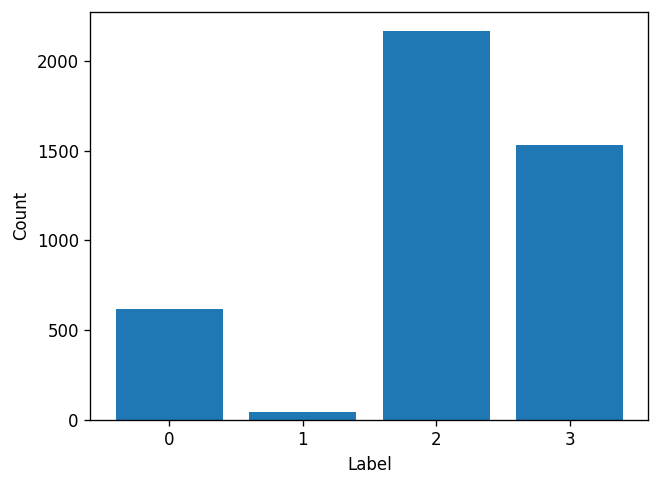

In [16]:
plt.figure(figsize = (6, 4.5), dpi = 120)
plt.bar(labels, counts)
plt.xticks(labels)
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

--- As the difference between the number of samples of classes 2 and 3 is not significant, especially in comaprison with the two other classes, augmentation techniques are being applied to the samples of classes 0 and 1.

--- Comparing the number of samples, I believe that for class 0, 2 new samples must be derived from each original image. On the other hand, for class 1, 33 samples should be created from each image to reach at least 1500 samples in total.

In [21]:
aug_net = keras.Sequential([
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomFlip(),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.4)
])

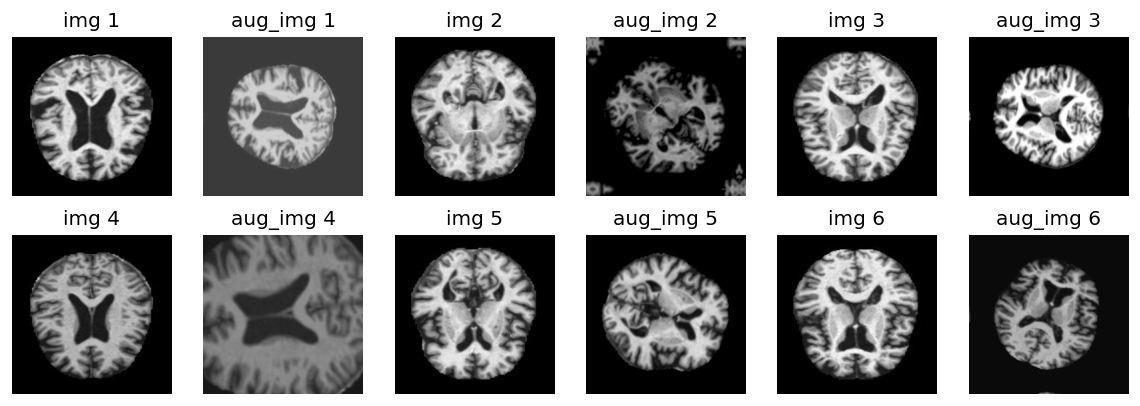

In [27]:
plt.figure(figsize = (12, 4), dpi = 120)
count = 0
for i in range(6):

  index = random.randint(0, len(X_train))

  ax = plt.subplot(2, 6, count + 1)
  plt.imshow(X_train[index])
  plt.axis(False)
  plt.title(f'img {i + 1}')

  ax = plt.subplot(2, 6, count + 2)
  aug_img = aug_net(X_train[index])
  plt.imshow(aug_img.numpy().astype('uint8'))
  plt.axis(False)
  plt.title(f'aug_img {i + 1}')

  count += 2

--- Putting the augmentation NN into tests, it performed well enough, and it is also stable. Thus, this NN is being used for deriving images from the original ones.

In [35]:
aug_images_class_0, aug_images_class_1 = [], []
for i in range(len(y_train)):

  if y_train[i] == 0:
    for rep in range(2):
      aug_img = aug_net(X_train[i])
      aug_images_class_0.append(aug_img.numpy().astype('uint8'))



  if y_train[i] == 1:
    for rep in range(33):
      aug_img = aug_net(X_train[i])
      aug_images_class_1.append(aug_img.numpy().astype('uint8'))

aug_images_class_0 = np.array(aug_images_class_0)
aug_images_class_1 = np.array(aug_images_class_1)

aug_images_class_0.shape, aug_images_class_1.shape

((1228, 240, 240, 3), (1485, 240, 240, 3))

In [43]:
y_aug_class_0 = np.zeros(shape = (1228,)).astype(int)
y_aug_class_1 = np.ones(shape = (1485,)).astype(int)

In [44]:
aug_images = np.vstack((aug_images_class_0, aug_images_class_1))
aug_labels = np.hstack((y_aug_class_0, y_aug_class_1))

aug_images.shape, aug_labels.shape

((2713, 240, 240, 3), (2713,))

--- Now for retaining our ability to perform trial-error process, the original train images and labels will not change, but new sets will be defined that consist both original and derived images and thier labels.

In [45]:
X_train_aug = np.vstack((X_train, aug_images))
y_train_aug = np.hstack((y_train, aug_labels))

X_train.shape, y_train.shape, X_train_aug.shape, y_train_aug.shape

((4352, 240, 240, 3), (4352,), (7065, 240, 240, 3), (7065,))

In [46]:
labels, counts = np.unique(y_train_aug, return_counts = True)

for i in range(len(labels)):
  print(f'{labels[i]} : {counts[i]}')

0 : 1842
1 : 1530
2 : 2164
3 : 1529


--- In the recently defined sets, the difference between the number of samples in each class with others is relatively lower than the original sets.

In [51]:
# shuffling both images and labels in the exact same order.
shuffler = np.random.permutation(len(y_train_aug))

X_train_aug = X_train_aug[shuffler]
y_train_aug = y_train_aug[shuffler]

## Training CNNs